Note: Use Python 3.9.18 or earlier version.

## Packages

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random

## Load Dataset

Here, we are using numpy as Keras is used with numpy

In [31]:
## Load Dataset
def load_dataset():
    datasets = ['real', 'easy', 'medium', 'hard']
    data_dict = {}
    for dataset in datasets:
        x_data = np.load(f'dataset/x_{dataset}.npy')
        y_data = np.load(f'dataset/y_{dataset}.npy')
        data_dict[dataset] = (x_data, y_data)
        print(f"{dataset}: X shape {x_data.shape}, Y shape {y_data.shape}")

    return data_dict

data_dict = load_dataset()

real: X shape (6000, 90, 90), Y shape (6000, 4)
easy: X shape (17931, 90, 90), Y shape (17931, 4)
medium: X shape (17067, 90, 90), Y shape (17067, 4)
hard: X shape (14272, 90, 90), Y shape (14272, 4)


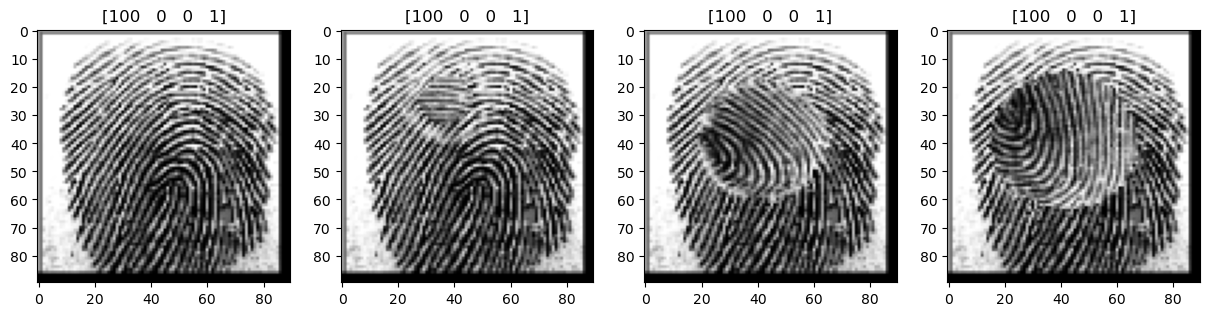

In [32]:
# Visualize a sample from each dataset
def visualize_samples(data_dict):
    plt.figure(figsize=(15, 10))
    for idx, (key, (x, y)) in enumerate(data_dict.items(), start=1):
        plt.subplot(1, 4, idx)
        plt.title(y[0])
        plt.imshow(x[0].squeeze(), cmap='gray')
    plt.show()

visualize_samples(data_dict)

# Train Test Split

In [33]:
x_data = np.concatenate([data_dict['easy'][0], data_dict['medium'][0], data_dict['hard'][0]], axis=0)
label_data = np.concatenate([data_dict['easy'][1], data_dict['medium'][1], data_dict['hard'][1]], axis=0)

# we use 90/10 split
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)
print(f"x_train: {x_train.shape}, label_train: {label_train.shape}")
print(f"x_val: {x_val.shape}, label_val: {label_val.shape}")

x_train: (44343, 90, 90), label_train: (44343, 4)
x_val: (4927, 90, 90), label_val: (4927, 4)


## Preview Augmentation

These are functions and transformations that will serve to transform and distort the original image that we will use for testing the trained model.


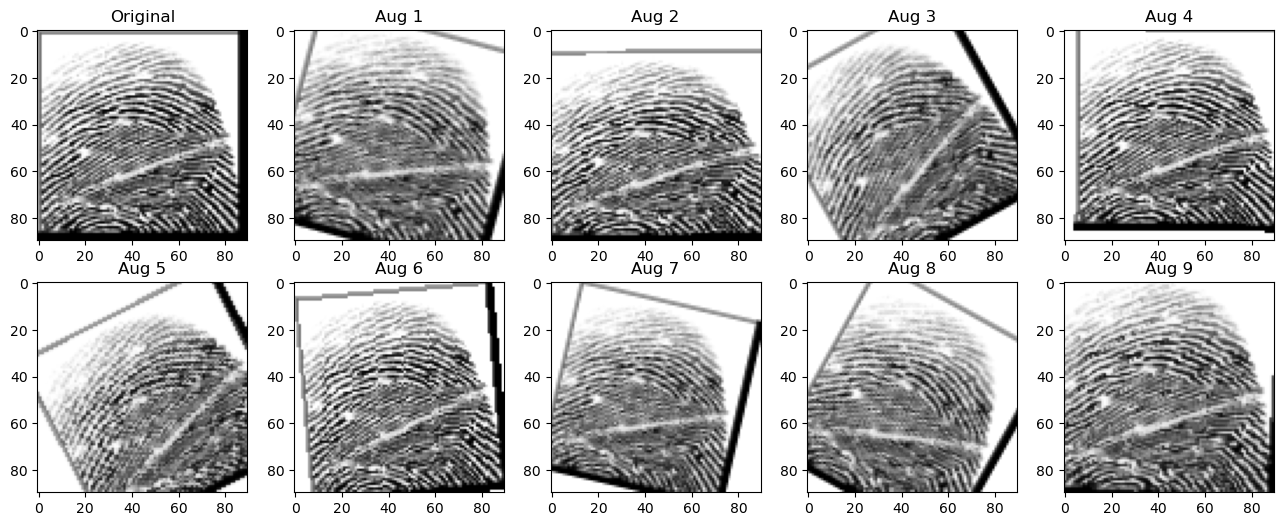

In [34]:
def preview_augmentation(images):
    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-30, 30),
            order=[0, 1],
            cval=255
        )
    ], random_order=True)

    augmented_images = seq.augment_images(images)
    
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 5, 1)
    plt.title('Original')
    plt.imshow(images[0].squeeze(), cmap='gray')
    for i, aug in enumerate(augmented_images):
        plt.subplot(2, 5, i + 2)
        plt.title(f'Aug {i + 1}')
        plt.imshow(aug.squeeze(), cmap='gray')
    plt.show()

preview_augmentation([x_data[40000]] * 9)

## Make Label Dictionary Lookup Table

This is used later on, to find the original index of a randomly picked sample from the validation set in order to compare the images for the testing.

In [35]:
label_real_dict = {''.join(y.astype(str)).zfill(6): i for i, y in enumerate(data_dict['real'][1])}

## Data Generator

This is necessary step in image processing using Keras, especially a big dataset that cannot fit into the memory during training. It is a class that produces batches of data that can feed into multiple cores right away.

In [36]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-30, 30),
                        order=[0, 1], cval=255)
            ], random_order=True)
            x1_batch = seq.augment_images(x1_batch)
        
        for i, l in enumerate(label_batch):
            match_key = ''.join(l.astype(str)).zfill(6)
            if random.random() > 0.5:
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]][..., np.newaxis]
                y_batch[i] = 1.
            else:
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                    if unmatch_key != match_key:
                        x2_batch[i] = self.x_real[unmatch_idx][..., np.newaxis]
                        break
                y_batch[i] = 0.
                
        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.x, self.label = shuffle(self.x, self.label)

In [37]:
# Here we create the DataGenerator class for train and validation set
train_gen = DataGenerator(x_train, label_train, data_dict['real'][0], label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, data_dict['real'][0], label_real_dict, shuffle=False)

## Create Model

Here is the concept of the model:
- 2 models with 2x Convolutional and Pooling layers, sharing weights
- The outputs are subtracted, and the subtraction is fed to another Conv + Pooling layer
- Then that is fed to a sigmoid for final classification if the 2 images are same or not

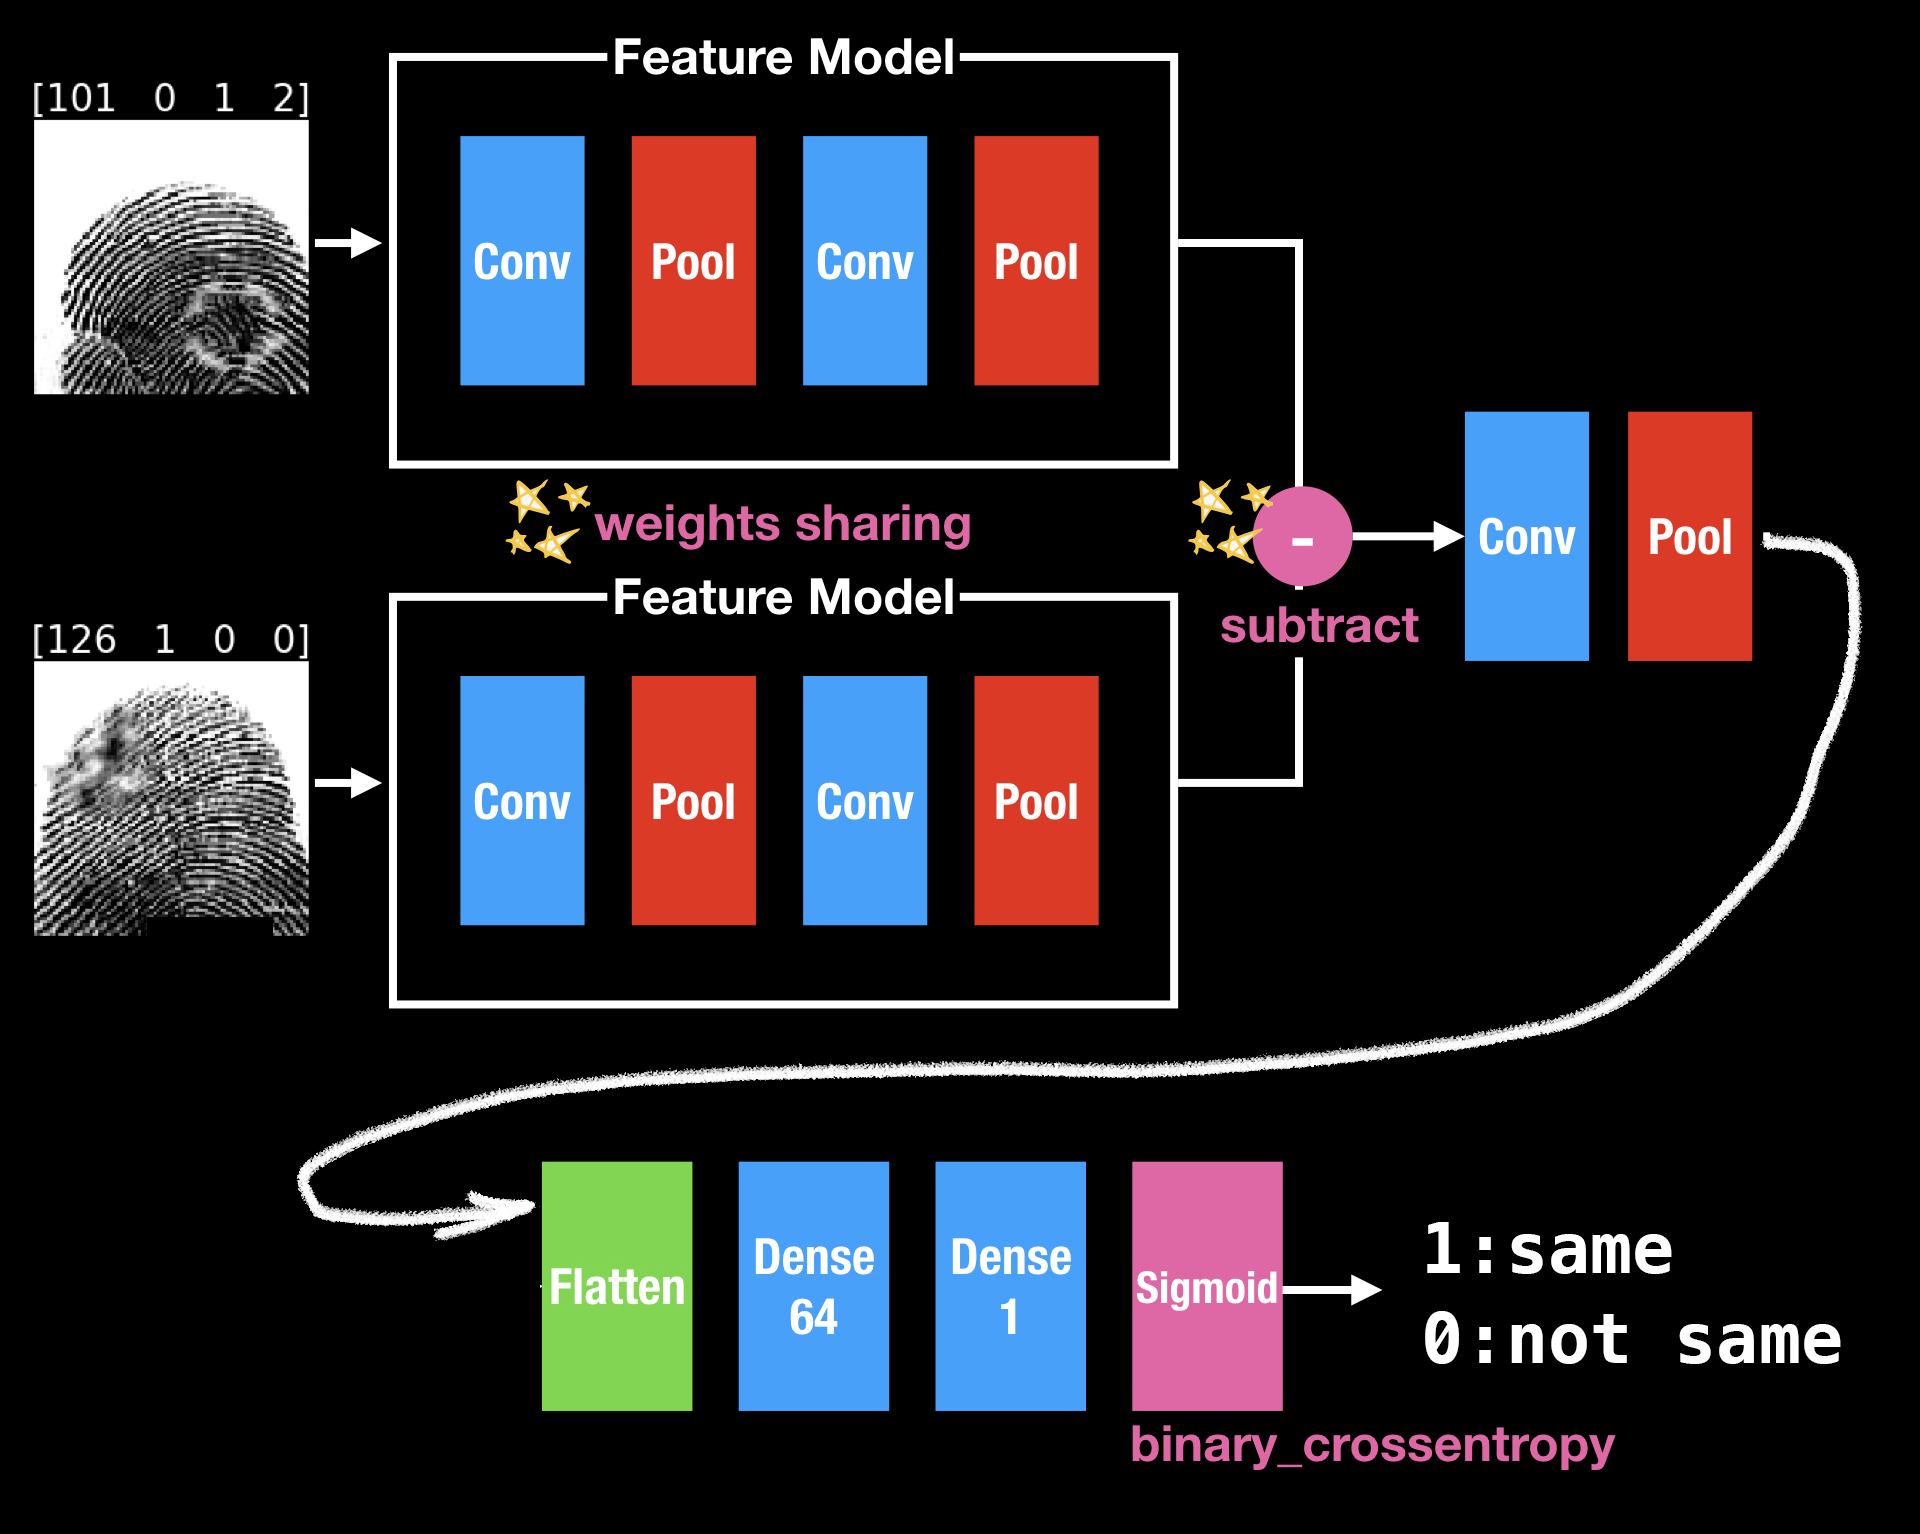

In [38]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Subtract
from tensorflow.keras.models import Model

def create_base_network(input_shape):
    """
    Function to create the base network (twin network) for the Siamese architecture.
    """
    input = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flatten the feature map
    x = Flatten()(x)

    return Model(input, x)

# Define the input shape for the images
input_shape = (90, 90, 1)

# Create the twin networks (base networks with shared weights)
base_network = create_base_network(input_shape)

# Define two input tensors for the two images
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Process each image through the shared twin network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the absolute difference between the feature vectors
subtracted = Subtract()([processed_a, processed_b])

# Further processing of the subtracted feature using another convolutional layer
x = Dense(128, activation='relu')(subtracted)
x = Dropout(0.5)(x)

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(x)

# Create the full Siamese network model
model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model_10 (Functional)          (None, 30976)        18816       ['input_17[0][0]',               
                                                                  'input_18[0][0]']               
                                                                                                  
 subtract_5 (Subtract)          (None, 30976)        0           ['model_10[0][0]',        

## Train

In other versons of the solutions, they used fit_generator method, which was commonly used in older versions of Keras to train models using data generators. However, since TensorFlow 2.1, fit can handle data generators directly. This unifies the API, making the code cleaner and more consistent. It also allows for better integration with TensorFlow’s functionalities such as distributed training and callbacks. Hence, using fit instead of fit_generator is the recommended approach now.

In [39]:
# Train the model using model.fit
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

Epoch 1/15
1385/1385 [==============================] - 251s 180ms/step - loss: 0.3161 - accuracy: 0.8642 - val_loss: 0.7544 - val_accuracy: 0.6319
Epoch 2/15
1385/1385 [==============================] - 276s 199ms/step - loss: 0.1839 - accuracy: 0.9328 - val_loss: 0.7348 - val_accuracy: 0.6859
Epoch 3/15
1385/1385 [==============================] - 820s 592ms/step - loss: 0.1577 - accuracy: 0.9429 - val_loss: 0.8706 - val_accuracy: 0.6742
Epoch 4/15
1385/1385 [==============================] - 239s 172ms/step - loss: 0.1403 - accuracy: 0.9508 - val_loss: 1.1064 - val_accuracy: 0.6599
Epoch 5/15
1385/1385 [==============================] - 253s 183ms/step - loss: 0.1308 - accuracy: 0.9541 - val_loss: 0.8006 - val_accuracy: 0.7179
Epoch 6/15
1385/1385 [==============================] - 275s 199ms/step - loss: 0.1210 - accuracy: 0.9592 - val_loss: 0.8613 - val_accuracy: 0.7202
Epoch 7/15
1385/1385 [==============================] - 332s 240ms/step - loss: 0.1177 - accuracy: 0.9602 - val_

## Evaluation

This is just a test using one random image and

1/1 [==============================] - 0s 17ms/step


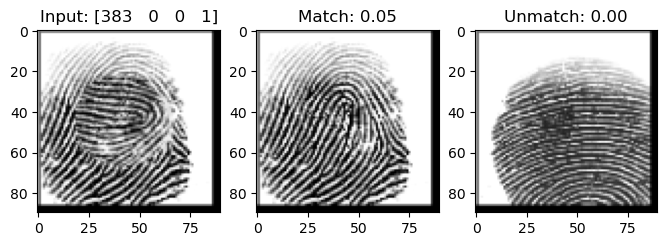

In [40]:
def evaluate_model(model, x_val, label_val):
    random_idx = random.randint(0, len(x_val))
    random_img = x_val[random_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    match_key = ''.join(label_val[random_idx].astype(str)).zfill(6)
    
    matched_img = data_dict['real'][0][label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    pred_matched = model.predict([random_img, matched_img])[0][0]
    
    unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
    unmatched_img = data_dict['real'][0][unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    pred_unmatched = model.predict([random_img, unmatched_img])[0][0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.title(f'Input: {label_val[random_idx]}')
    plt.imshow(random_img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f'Match: {pred_matched:.2f}')
    plt.imshow(matched_img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f'Unmatch: {pred_unmatched:.2f}')
    plt.imshow(unmatched_img.squeeze(), cmap='gray')
    plt.show()

evaluate_model(model, x_val, label_val)

## Model Validation

We will take a look at the confusion matrix, Precision and AUC curve in order to validate the model.

In [49]:
# Predictions on the validation set
y_true = []
y_pred = []

# Collect true labels and predictions
for batch in val_gen:
    x_batch, y_batch = batch  # Unpack the batch
    x1_batch, x2_batch = x_batch  # Unpack the input pairs (x1 and x2)
    
    # Ensure x1_batch and x2_batch have the correct shape
    if len(x1_batch.shape) == 3:  # Add channel dimension if missing
        x1_batch = x1_batch[..., np.newaxis]
    if len(x2_batch.shape) == 3:  # Add channel dimension if missing
        x2_batch = x2_batch[..., np.newaxis]
    
    predictions = model.predict([x1_batch, x2_batch])
    y_true.extend(y_batch)
    y_pred.extend(predictions)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels (assuming binary classification with a threshold of 0.5)
y_pred_labels = np.where(y_pred > 0.5, 1, 0)


1/1 [==============================] - 0s 59ms/step


Let's plot that.

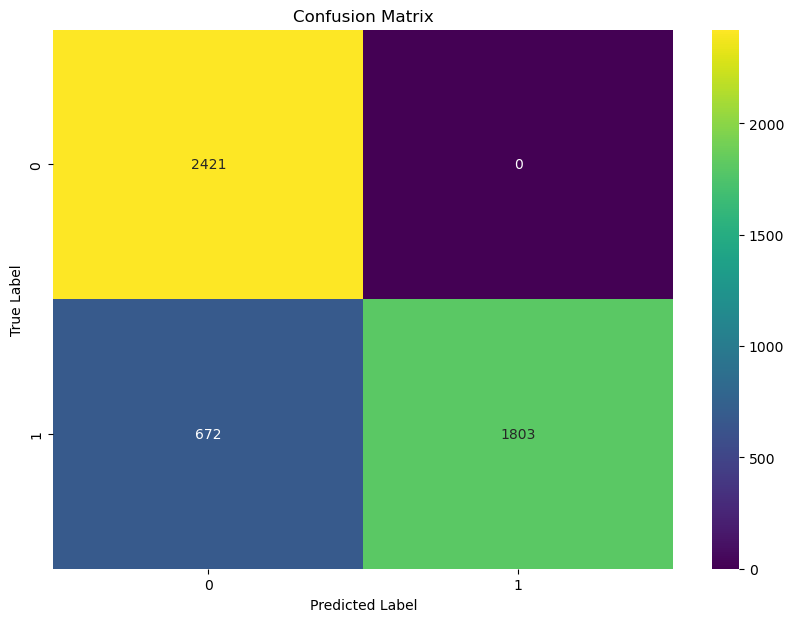

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      2421
         1.0       1.00      0.73      0.84      2475

    accuracy                           0.86      4896
   macro avg       0.89      0.86      0.86      4896
weighted avg       0.89      0.86      0.86      4896



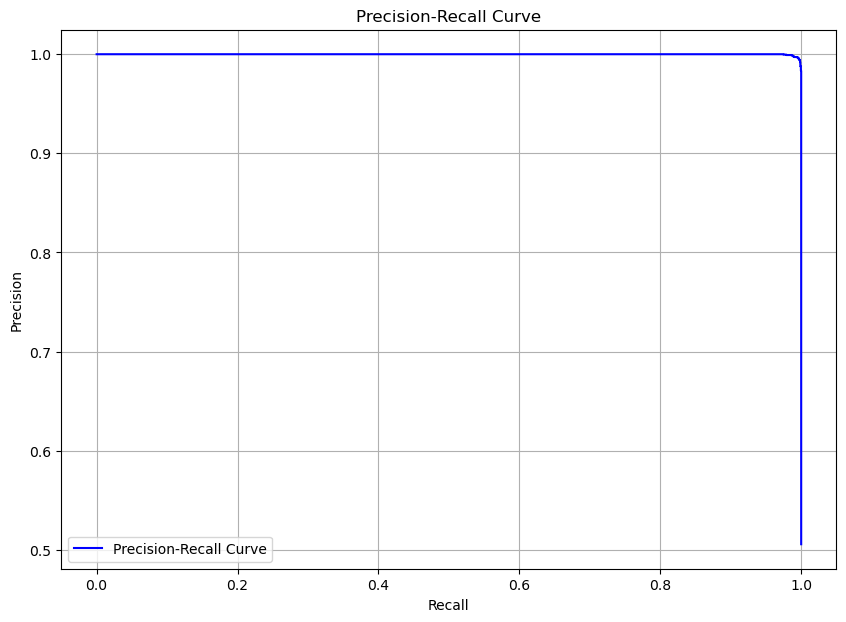

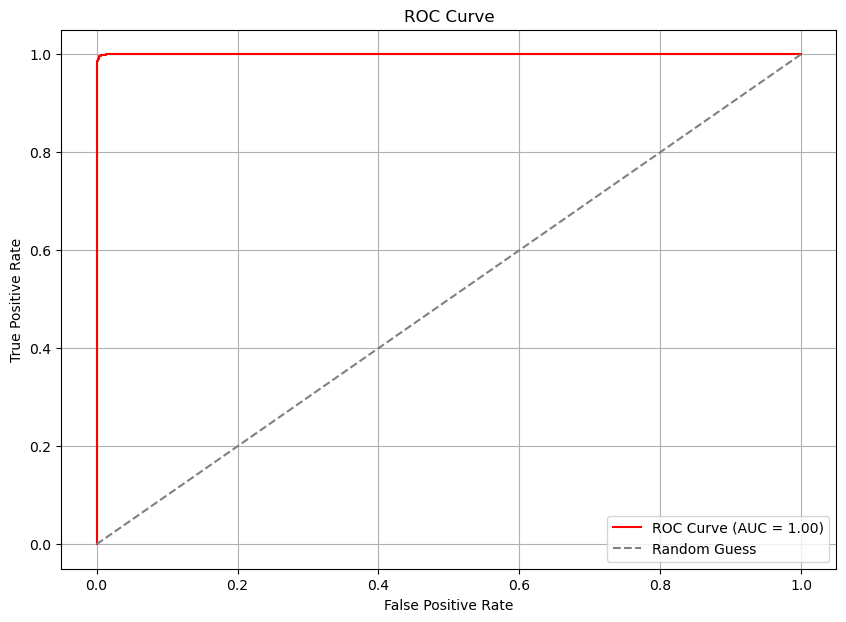

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Alternatively, use seaborn to create a more informative heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print a classification report for more detailed metrics
print(classification_report(y_true, y_pred_labels))

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='r', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Model Validation Summary

The fingerprint recognition model was trained and validated using the SOCOFing dataset, augmented with deformations such as obliteration, central rotation, and z-cut. These augmented images were compared against their original counterparts to assess the model’s robustness. The goal of this approach is to simulate real-world scenarios where fingerprints might be damaged or distorted, ensuring the model performs reliably under such conditions.

**Confusion Matrix Analysis:**

**Precision:** Indicates the proportion of predicted positives that are correct:

	•	0.78 for class 0.0 (non-matching fingerprint).
	•	1.00 for class 1.0 (matching fingerprint).
High precision for 1.0 ensures minimal false positives, which is crucial for security applications.

**Recall:** Reflects the proportion of actual positives identified:

	•	1.00 for class 0.0.
	•	0.73 for class 1.0.
Lower recall for 1.0 indicates that some matching fingerprints are not being identified.

**F1-Score:** The harmonic mean of precision and recall:

	•	0.88 for class 0.0.
	•	0.84 for class 1.0.
Overall Accuracy: 86% across 4896 samples.

**Precision-Recall Curve:**

The precision-recall curve demonstrates that precision remains high across most recall values. This is a positive indicator for the model’s ability to maintain precision even as recall increases, minimizing false positives in critical scenarios.

**ROC Curve:**

The receiver operating characteristic (ROC) curve shows a perfect area under the curve (AUC) of 1.00, indicating near-perfect separability between matching (1.0) and non-matching (0.0) fingerprints.

**Importance of Avoiding False Positives:**

In security systems, false positives (incorrectly classifying a non-matching fingerprint as a match) can lead to severe breaches. The model’s perfect precision for class 1.0 ensures that false positives are entirely avoided in this evaluation. However, the lower recall for class 1.0 suggests some genuine matches might be missed, which could reduce user experience in certain applications.

**Suggestions for Model Improvement:**

	1.	Improve Recall for Matching Fingerprints (1.0):
		•	Use class-balanced loss functions such as Focal Loss to emphasize harder-to-classify cases.
		•	Apply cost-sensitive learning by penalizing false negatives more than false positives.
		•	Conduct active learning to focus on difficult-to-classify examples during training.
	2.	Enhance Augmentation Techniques:
		•	Introduce more diverse deformations, such as blurring, smudging, and extreme rotation, to better simulate adversarial conditions.
		•	Use adversarial data augmentation to train the model against synthetic “hard examples” generated by adversarial algorithms.
	3.	Feature Engineering:
		•	Leverage additional fingerprint-specific features (e.g., minutiae points, ridge counts) alongside CNN-based methods.
		•	Experiment with multi-modal learning, combining image features with auxiliary data (e.g., timestamp or context) for enhanced accuracy.
	4.	Post-Processing and Threshold Tuning:
		•	Adjust the decision threshold to balance precision and recall, depending on application requirements.
		•	Use probabilistic calibration (e.g., Platt Scaling) to fine-tune the model’s confidence scores.


## Conclusion

The model demonstrates strong potential for fingerprint recognition, achieving high precision and an AUC of 1.00. However, improvements in recall for matching fingerprints and robustness to further deformations could enhance its applicability in security-sensitive environments. By leveraging advanced training techniques, augmentation strategies, and architecture refinements, the model can achieve even higher reliability and robustness.